In [3]:
import numpy as np, pandas as pd
rng = np.random.default_rng(42)

def synth(n_per_group=1000, pA=0.18, uplift_abs=0.02):
    countries = ["US","IN","CA"]; cp = [0.6, 0.3, 0.1]
    devices = ["iOS","Android"];  dp = [0.4, 0.6]

    def gen(prefix, n, base_p):
        d = pd.DataFrame({
            "user_id": [f"{prefix}_{i}" for i in range(n)],
            "variant": prefix,
            "country": rng.choice(countries, size=n, p=cp),
            "device":  rng.choice(devices,  size=n, p=dp),
        })
        adj = (d.country.eq("US").astype(int)*0.01
               - d.device.eq("Android").astype(int)*0.015)
        p = np.clip(base_p + adj, 0.01, 0.95)
        d["activated"] = rng.binomial(1, p)
        return d

    return pd.concat([gen("A", n_per_group, pA),
                      gen("B", n_per_group, pA + uplift_abs)], ignore_index=True)

df = synth()
df.to_csv("ab_onboarding_full.csv", index=False)
print("Saved ab_onboarding_full.csv")
print(df["variant"].value_counts())

Saved ab_onboarding_full.csv
variant
A    1000
B    1000
Name: count, dtype: int64


In [4]:
import pandas as pd
df = pd.read_csv("ab_onboarding_full.csv")
df["variant"].value_counts(), df.shape

(variant
 A    1000
 B    1000
 Name: count, dtype: int64,
 (2000, 5))

In [5]:
import os

# 1. Absolute file path
print("File location:", os.path.abspath("ab_onboarding_full.csv"))

# 2. Preview first 10 rows
print("\nFirst 10 rows:")
print(df.head(10))

File location: /Users/shauryadityasingh/Downloads/ab_onboarding_full.csv

First 10 rows:
  user_id variant country   device  activated
0     A_0       A      IN      iOS          1
1     A_1       A      US  Android          0
2     A_2       A      IN      iOS          1
3     A_3       A      IN      iOS          0
4     A_4       A      US  Android          0
5     A_5       A      CA      iOS          1
6     A_6       A      IN  Android          0
7     A_7       A      IN      iOS          0
8     A_8       A      US  Android          0
9     A_9       A      US  Android          0


In [6]:
# Only A/B variants?
print("Unique variants:", df["variant"].unique())

# Any missing values?
print("\nMissing values:\n", df.isna().sum())

# Rough slice counts (country x variant)
print("\nBy country:\n", df.groupby(['variant','country']).size())

# Rough slice counts (device x variant)
print("\nBy device:\n", df.groupby(['variant','device']).size())

Unique variants: ['A' 'B']

Missing values:
 user_id      0
variant      0
country      0
device       0
activated    0
dtype: int64

By country:
 variant  country
A        CA          98
         IN         299
         US         603
B        CA         103
         IN         292
         US         605
dtype: int64

By device:
 variant  device 
A        Android    613
         iOS        387
B        Android    583
         iOS        417
dtype: int64


In [7]:
conv = (df.groupby('variant')['activated']
          .agg(['mean','sum','count'])
          .rename(columns={'mean':'activation_rate', 'sum':'success', 'count':'n'}))
print(conv)

# Grab numbers for A and B
success_A = int(conv.loc['A','success'])
n_A       = int(conv.loc['A','n'])
success_B = int(conv.loc['B','success'])
n_B       = int(conv.loc['B','n'])

pA = success_A / n_A
pB = success_B / n_B
print(f"pA={pA:.3f}, pB={pB:.3f}, uplift_abs={pB-pA:.3f}")

         activation_rate  success     n
variant                                
A                  0.171      171  1000
B                  0.189      189  1000
pA=0.171, pB=0.189, uplift_abs=0.018


In [8]:
from math import sqrt
from scipy.stats import norm

# Values from Step 3
success_A, n_A = 171, 1000
success_B, n_B = 189, 1000
pA, pB = success_A/n_A, success_B/n_B

# Pooled proportion
p_pool = (success_A + success_B) / (n_A + n_B)
se = sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))

# z-statistic and p-value
z = (pB - pA) / se
p_value = 2 * (1 - norm.cdf(abs(z)))

print(f"z = {z:.2f}, p-value = {p_value:.4f}")

z = 1.05, p-value = 0.2948


In [9]:
def wilson_ci(success, n, alpha=0.05):
    if n == 0:
        return (0.0, 0.0)
    z = norm.ppf(1 - alpha/2)
    p = success / n
    denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    half = z * sqrt((p*(1-p) + z*z/(4*n))/n) / denom
    return center - half, center + half

ciA = wilson_ci(success_A, n_A)
ciB = wilson_ci(success_B, n_B)
print(f"A 95% CI: [{ciA[0]:.3f}, {ciA[1]:.3f}]  |  B 95% CI: [{ciB[0]:.3f}, {ciB[1]:.3f}]")

A 95% CI: [0.149, 0.196]  |  B 95% CI: [0.166, 0.214]


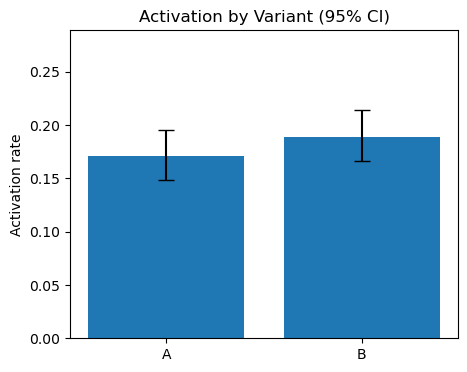

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm

success_A, n_A = 171, 1000
success_B, n_B = 189, 1000
pA, pB = success_A/n_A, success_B/n_B

def wilson_ci(success, n, alpha=0.05):
    z = norm.ppf(1 - alpha/2); p = success/n
    denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    half = z * sqrt((p*(1-p) + z*z/(4*n))/n) / denom
    return center - half, center + half

ciA = wilson_ci(success_A, n_A)
ciB = wilson_ci(success_B, n_B)

labels = np.array(['A','B'])
rates  = np.array([pA, pB], dtype=float)
yerr = np.vstack([[pA - ciA[0], pB - ciB[0]],
                  [ciA[1] - pA, ciB[1] - pB]]).astype(float)

plt.figure(figsize=(5,4))
plt.bar(labels, rates, yerr=yerr, capsize=6)
plt.ylabel('Activation rate')
plt.title('Activation by Variant (95% CI)')
plt.ylim(0, float(max(rates) + 0.1))
plt.show()

In [11]:
import numpy as np
from statsmodels.stats.power import NormalIndPower

# baseline and target rates
pA = 0.171
pB = 0.189
alpha = 0.05
power = 0.8

# manual Cohen's h
def proportion_effectsize(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

effect_size = proportion_effectsize(pA, pB)

analysis = NormalIndPower()
required_n = analysis.solve_power(effect_size=abs(effect_size), power=power, alpha=alpha, ratio=1)

print(f"Required sample size per group (80% power, 5% alpha): {int(required_n)} users")

Required sample size per group (80% power, 5% alpha): 7147 users


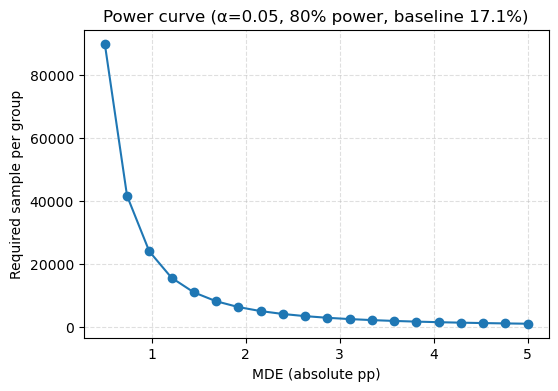

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower

pA = 0.171
alpha = 0.05
power = 0.80

def proportion_effectsize(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

mdes = np.linspace(0.005, 0.05, 20)  # 0.5 pp to 5.0 pp
n_per_group = []
analysis = NormalIndPower()

for mde in mdes:
    pB = pA + mde
    h = abs(proportion_effectsize(pA, pB))
    n = analysis.solve_power(effect_size=h, power=power, alpha=alpha, ratio=1)
    n_per_group.append(n)

plt.figure(figsize=(6,4))
plt.plot(mdes*100, n_per_group, marker='o')
plt.xlabel("MDE (absolute pp)")
plt.ylabel("Required sample per group")
plt.title("Power curve (α=0.05, 80% power, baseline 17.1%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()